<div style="background-color:#166534; color:#fde047; padding: 25px; border-radius: 10px; text-align:left;">
  <h1 style="font-size:26px; font-family:calibri;"><b>📦 Predicting Uber Ride Cancellations 🚕</b></h1>
  <p style="font-size:18px; font-family:calibri; line-height:1.6em;">
    A fast, interpretable pipeline to predict ride cancellations using XGBoost
  </p>
</div>


<div style="background-color:#166534; color:#fde047; padding: 20px; border-radius: 10px;">
  <h2 style="font-size:22px; font-family:calibri;"><b>🧠 Introduction: Why This Matters</b></h2>
  <p style="font-size:18px; font-family:calibri; line-height:1.6em;">
    Every cancelled ride is lost revenue, wasted time, and a signal of potential churn.
    <br><br>
    By predicting ride cancellations before they happen, ride-hailing platforms can:
  </p>
  <ul style="font-size:18px; font-family:calibri; line-height:1.8em;">
    <li>🚗 Improve customer experience</li>
    <li>📍 Optimize driver dispatch</li>
    <li>📉 Reduce operational inefficiencies</li>
  </ul>
  <p style="font-size:18px; font-family:calibri;">
    This notebook builds a model to flag cancellations using only pre-ride information — no leakage, full interpretability.
  </p>
</div>

<div style="background-color:#166534; color:#fde047; padding: 20px; border-radius: 10px;">
  <h2 style="font-size:22px; font-family:calibri;"><b>📌 Problem Statement</b></h2>
  <p style="font-size:18px; font-family:calibri; line-height:1.6em;">
    Can we predict if a customer will cancel an Uber ride <b>before it begins</b>, using only booking metadata?
    <br><br>
    🧪 <b>Task:</b> Binary classification  
    🎯 <b>Target:</b> <code>target_customer_cancelled</code> (1 = cancelled, 0 = not)  
    ⚠️ <b>Note:</b> Labels are imbalanced (~7% cancellations)
  </p>
</div>

<div style="background-color:#166534; color:#fde047; padding: 20px; border-radius: 10px;">
  <h2 style="font-size:22px; font-family:calibri;"><b>🛠️ Project Workflow</b></h2>
  <ul style="font-size:18px; font-family:calibri; line-height:1.8em;">
    <li>🧼 Data Cleaning</li>
    <li>🔍 Exploratory Data Analysis (EDA)</li>
    <li>🛠 Feature Engineering</li>
    <li>⚖️ Handle Class Imbalance (undersampling or class weights)</li>
    <li>🌲 Train Logistic Regression, Random Forest and XGBoost Model</li>
    <li>📈 Evaluate using ROC AUC and F1</li>
    <li>📝 Highlight findings and model insights</li>
  </ul>
</div>

# Load and Show First Rows

In [ ]:
import pandas as pd


df = pd.read_csv("ncr_ride_bookings.csv")


df.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,Date,Time,Booking ID,Booking Status,Customer ID,Vehicle Type,Pickup Location,Drop Location,Avg VTAT,Avg CTAT,...,Reason for cancelling by Customer,Cancelled Rides by Driver,Driver Cancellation Reason,Incomplete Rides,Incomplete Rides Reason,Booking Value,Ride Distance,Driver Ratings,Customer Rating,Payment Method
0,2024-03-23,12:29:38,"""CNR5884300""",No Driver Found,"""CID1982111""",eBike,Palam Vihar,Jhilmil,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-11-29,18:01:39,"""CNR1326809""",Incomplete,"""CID4604802""",Go Sedan,Shastri Nagar,Gurgaon Sector 56,4.9,14.0,...,NaN,NaN,NaN,1.0,Vehicle Breakdown,237.0,5.73,NaN,NaN,UPI
2,2024-08-23,08:56:10,"""CNR8494506""",Completed,"""CID9202816""",Auto,Khandsa,Malviya Nagar,13.4,25.8,...,NaN,NaN,NaN,NaN,NaN,627.0,13.58,4.9,4.9,Debit Card
3,2024-10-21,17:17:25,"""CNR8906825""",Completed,"""CID2610914""",Premier Sedan,Central Secretariat,Inderlok,13.1,28.5,...,NaN,NaN,NaN,NaN,NaN,416.0,34.02,4.6,5.0,UPI
4,2024-09-16,22:08:00,"""CNR1950162""",Completed,"""CID9933542""",Bike,Ghitorni Village,Khan Market,5.3,19.6,...,NaN,NaN,NaN,NaN,NaN,737.0,48.21,4.1,4.3,UPI


# Data Types, Summary Stats, and Null Values

In [ ]:

print("Data Info:")
df.info()

print("\n Summary Statistics:")
print(df.describe(include='all'))

print("\nNull Values per Column:")
print(df.isnull().sum())

📌 Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 21 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Date                               150000 non-null  object 
 1   Time                               150000 non-null  object 
 2   Booking ID                         150000 non-null  object 
 3   Booking Status                     150000 non-null  object 
 4   Customer ID                        150000 non-null  object 
 5   Vehicle Type                       150000 non-null  object 
 6   Pickup Location                    150000 non-null  object 
 7   Drop Location                      150000 non-null  object 
 8   Avg VTAT                           139500 non-null  float64
 9   Avg CTAT                           102000 non-null  float64
 10  Cancelled Rides by Customer        10500 non-null   float64
 11  Reason for cancelling by C

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


# Timestamp Processing

In [ ]:

df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S', errors='coerce').dt.time


df['datetime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'].astype(str), errors='coerce')


df['hour'] = df['datetime'].dt.hour
df['day'] = df['datetime'].dt.day
df['month'] = df['datetime'].dt.month
df['weekday'] = df['datetime'].dt.dayofweek  
df['is_weekend'] = df['weekday'].isin([5, 6])


df[['datetime', 'hour', 'day', 'month', 'weekday', 'is_weekend']].head()

,datetime,hour,day,month,weekday,is_weekend
0,2024-03-23 12:29:38,12,23,3,5,True
1,2024-11-29 18:01:39,18,29,11,4,False
2,2024-08-23 08:56:10,8,23,8,4,False
3,2024-10-21 17:17:25,17,21,10,0,False
4,2024-09-16 22:08:00,22,16,9,0,False


# Missing Value Strategy

In [ ]:

df['is_cancelled_customer'] = df['Cancelled Rides by Customer'].notnull()
df['is_cancelled_driver'] = df['Cancelled Rides by Driver'].notnull()
df['is_incomplete'] = df['Incomplete Rides'].notnull()

df['missing_driver_rating'] = df['Driver Ratings'].isnull()
df['missing_customer_rating'] = df['Customer Rating'].isnull()
df['missing_booking_value'] = df['Booking Value'].isnull()
df['missing_payment_method'] = df['Payment Method'].isnull()


df['Avg VTAT'] = df['Avg VTAT'].fillna(df['Avg VTAT'].median())
df['Avg CTAT'] = df['Avg CTAT'].fillna(df['Avg CTAT'].median())



df[['is_cancelled_customer', 'is_cancelled_driver', 'is_incomplete',
    'missing_driver_rating', 'missing_customer_rating',
    'missing_booking_value', 'missing_payment_method']].sum()

is_cancelled_customer      10500
is_cancelled_driver        27000
is_incomplete               9000
missing_driver_rating      57000
missing_customer_rating    57000
missing_booking_value      48000
missing_payment_method     48000
dtype: int64

# Define Target for Customer Cancellation

In [ ]:

df['target_customer_cancelled'] = df['is_cancelled_customer'].astype(int)


df['target_customer_cancelled'].value_counts(normalize=True)

target_customer_cancelled
0    0.93
1    0.07
Name: proportion, dtype: float64

# EDA for Customer Cancellations

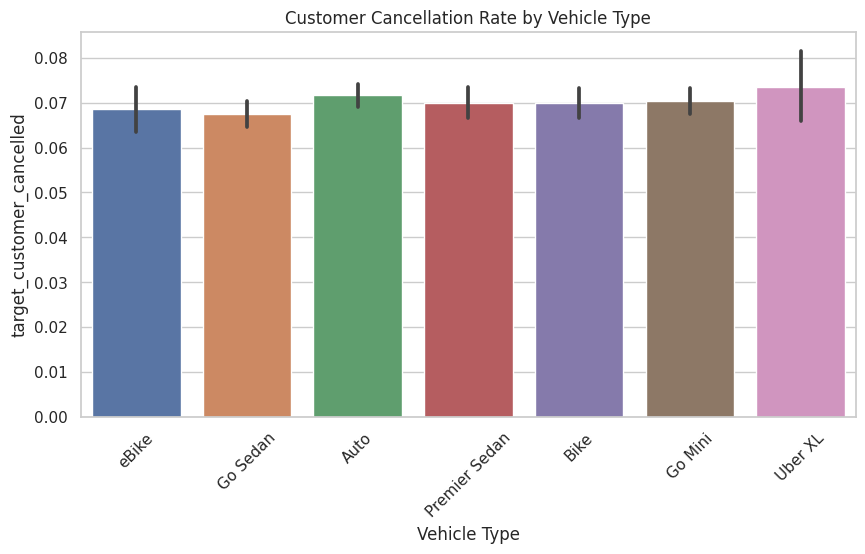

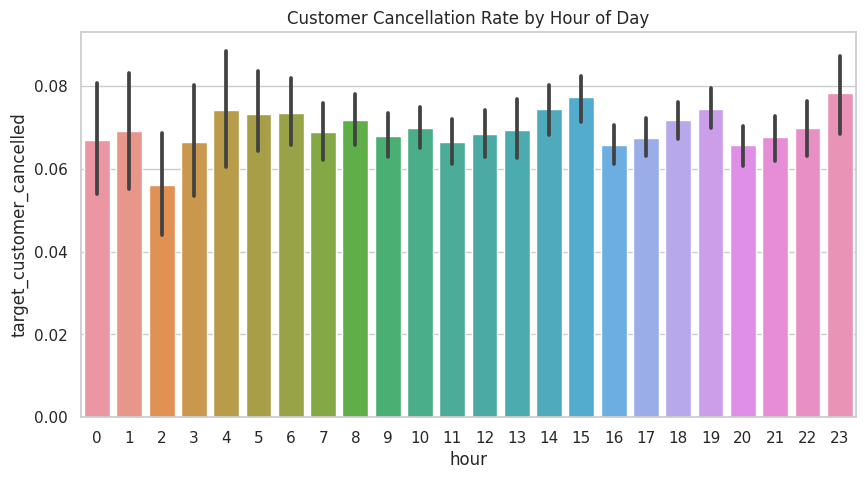

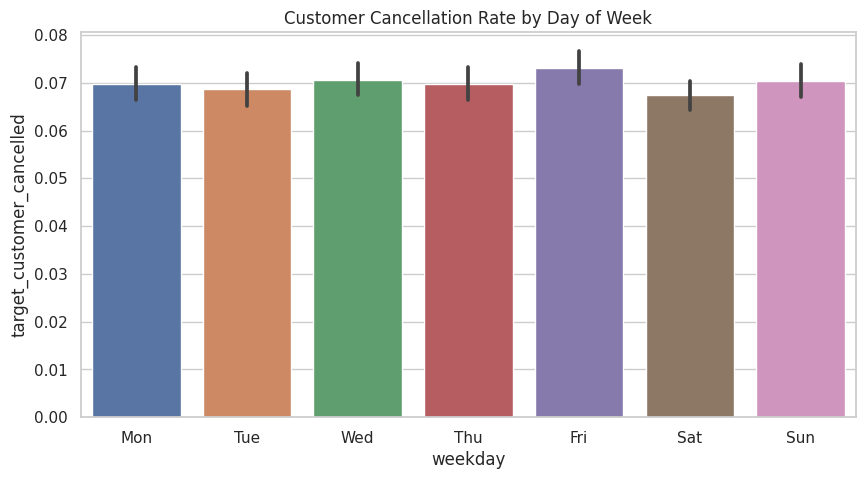

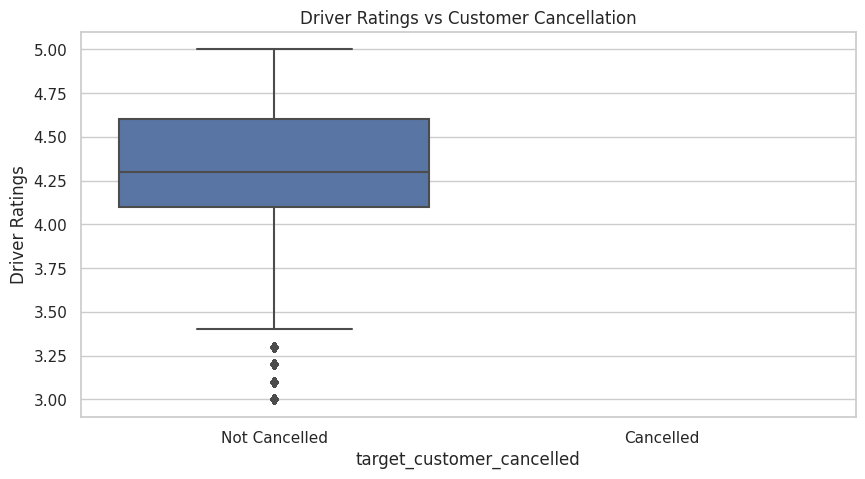

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")


plt.figure(figsize=(10, 5))
sns.barplot(data=df, x='Vehicle Type', y='target_customer_cancelled')
plt.title("Customer Cancellation Rate by Vehicle Type")
plt.xticks(rotation=45)
plt.show()


plt.figure(figsize=(10, 5))
sns.barplot(data=df, x='hour', y='target_customer_cancelled')
plt.title("Customer Cancellation Rate by Hour of Day")
plt.show()


plt.figure(figsize=(10, 5))
sns.barplot(data=df, x='weekday', y='target_customer_cancelled')
plt.title("Customer Cancellation Rate by Day of Week")
plt.xticks(ticks=range(7), labels=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
plt.show()


plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='target_customer_cancelled', y='Driver Ratings')
plt.title("Driver Ratings vs Customer Cancellation")
plt.xticks([0, 1], ['Not Cancelled', 'Cancelled'])
plt.show()

# Location + Time EDA

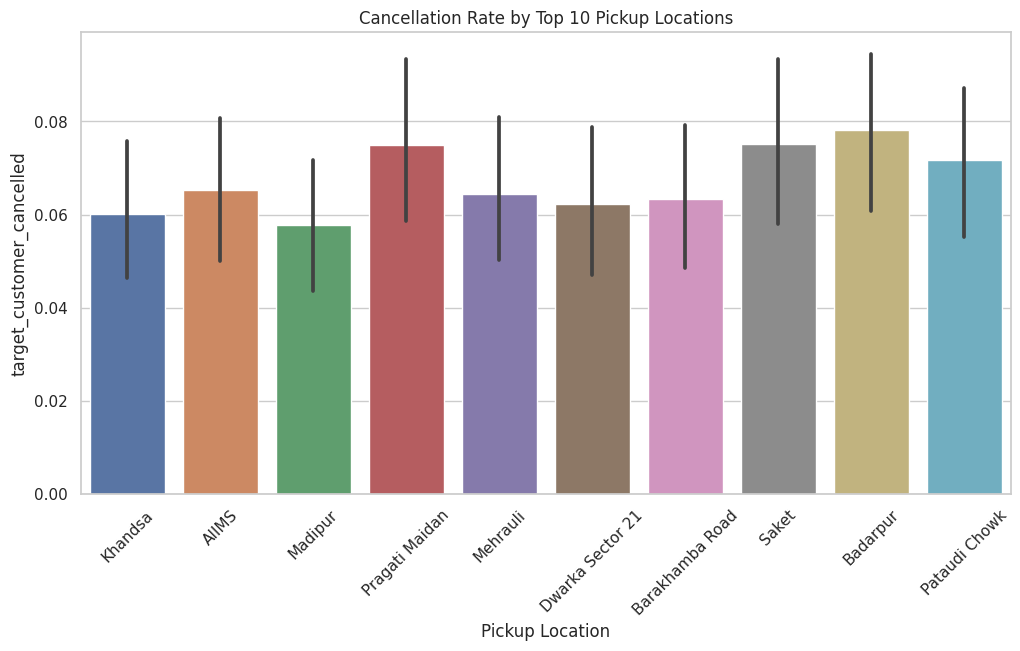

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


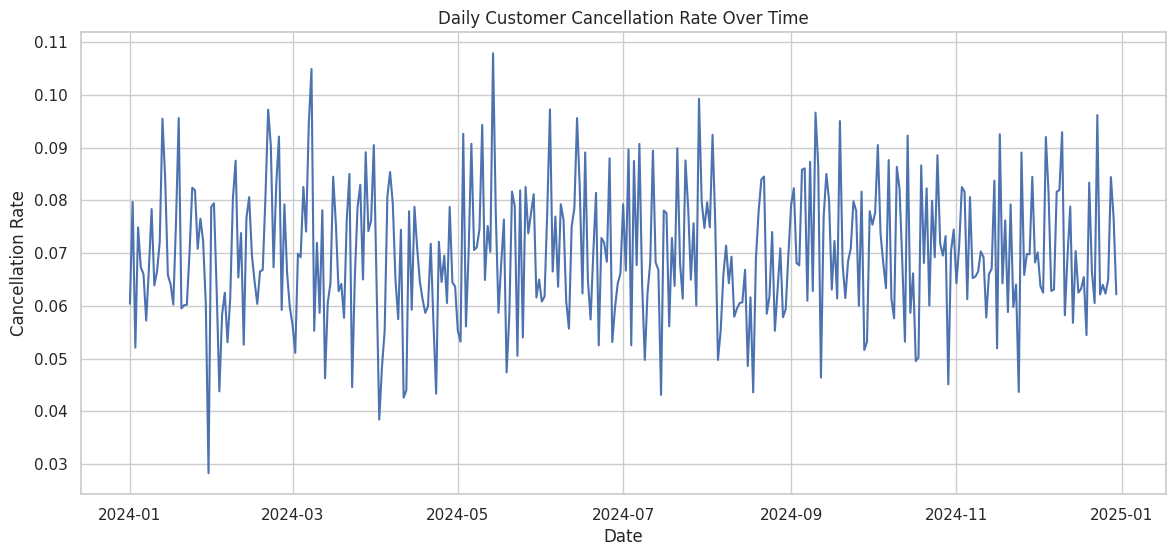

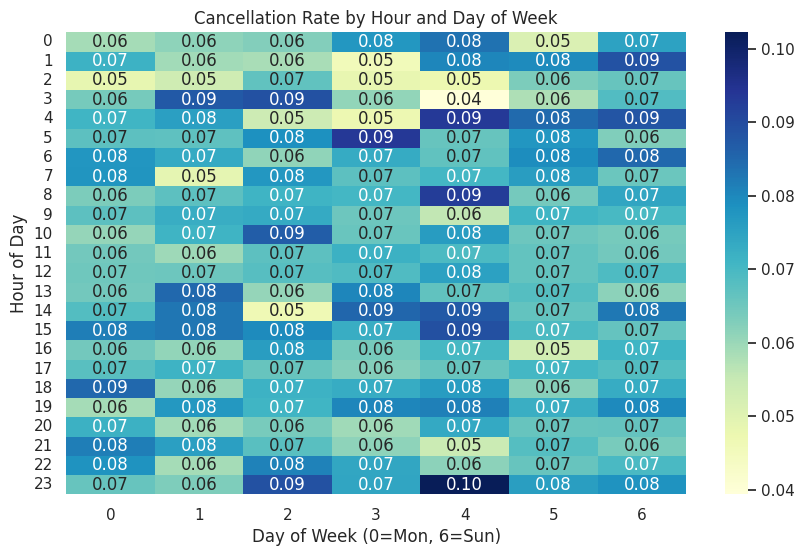

In [ ]:

top_pickups = df['Pickup Location'].value_counts().nlargest(10).index
df_top_pickups = df[df['Pickup Location'].isin(top_pickups)]

plt.figure(figsize=(12, 6))
sns.barplot(data=df_top_pickups, x='Pickup Location', y='target_customer_cancelled')
plt.title("Cancellation Rate by Top 10 Pickup Locations")
plt.xticks(rotation=45)
plt.show()


df_daily = df.groupby('Date')['target_customer_cancelled'].mean().reset_index()

plt.figure(figsize=(14, 6))
sns.lineplot(data=df_daily, x='Date', y='target_customer_cancelled')
plt.title("Daily Customer Cancellation Rate Over Time")
plt.ylabel("Cancellation Rate")
plt.xlabel("Date")
plt.show()


heatmap_data = df.pivot_table(
    index='hour',
    columns='weekday',
    values='target_customer_cancelled',
    aggfunc='mean'
)

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, cmap="YlGnBu", annot=True, fmt=".2f")
plt.title("Cancellation Rate by Hour and Day of Week")
plt.ylabel("Hour of Day")
plt.xlabel("Day of Week (0=Mon, 6=Sun)")
plt.show()

# Feature Engineering

In [ ]:
from sklearn.preprocessing import LabelEncoder


df = pd.get_dummies(df, columns=['Vehicle Type'], prefix='vehicle', drop_first=True)


top_pickups = df['Pickup Location'].value_counts().nlargest(10).index
df['pickup_encoded'] = df['Pickup Location'].apply(lambda x: x if x in top_pickups else 'Other')
df = pd.get_dummies(df, columns=['pickup_encoded'], prefix='pickup', drop_first=True)


top_drops = df['Drop Location'].value_counts().nlargest(10).index
df['drop_encoded'] = df['Drop Location'].apply(lambda x: x if x in top_drops else 'Other')
df = pd.get_dummies(df, columns=['drop_encoded'], prefix='drop', drop_first=True)


cust_counts = df['Customer ID'].value_counts().to_dict()
df['customer_total_bookings'] = df['Customer ID'].map(cust_counts)


num_cols = ['Avg VTAT', 'Avg CTAT', 'Driver Ratings', 'Customer Rating']

drop_cols = [
    'Booking ID', 'Customer ID', 'Pickup Location', 'Drop Location',
    'Cancelled Rides by Customer', 'Reason for cancelling by Customer',
    'Cancelled Rides by Driver', 'Driver Cancellation Reason',
    'Incomplete Rides', 'Incomplete Rides Reason', 'Date', 'Time', 'datetime'
]
df.drop(columns=drop_cols, inplace=True)


features = [col for col in df.columns if col != 'target_customer_cancelled']
target = 'target_customer_cancelled'

print(f"Total Features for Modeling: {len(features)}")

✅ Total Features for Modeling: 47


# Apply Class Weights

We'll compute balanced class weights based on the distribution of target_customer_cancelled, and use those in the model training phase.

In [ ]:
from sklearn.utils.class_weight import compute_class_weight


class_weights = compute_class_weight(
    class_weight='balanced',
    classes=[0, 1],
    y=df['target_customer_cancelled']
)

weights = dict(enumerate(class_weights))
print("Class Weights:", weights)

Class Weights: {0: 0.5376344086021505, 1: 7.142857142857143}


In [ ]:
import numpy as np


temp_df = df.copy()
temp_df['target'] = df[target]


numeric_cols = temp_df.select_dtypes(include=[np.number]).columns


correlations = temp_df[numeric_cols].corr()['target'].sort_values(key=abs, ascending=False)


print("Top Correlated Features with Target:\n")
print(correlations.drop('target'))

📌 Top Correlated Features with Target:

target_customer_cancelled    1.000000
Avg VTAT                     0.306592
Avg CTAT                    -0.008883
month                        0.001480
hour                         0.001475
customer_total_bookings      0.001330
day                         -0.000854
weekday                      0.000595
Booking Value                     NaN
Ride Distance                     NaN
Driver Ratings                    NaN
Customer Rating                   NaN
Name: target, dtype: float64


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


# Logistic Regression with Class Weights

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score


clean_features = df.select_dtypes(include=['number']).columns.drop('target_customer_cancelled')


X = df[clean_features]
y = df['target_customer_cancelled']

imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y, test_size=0.2, stratify=y, random_state=42
)


logreg = LogisticRegression(class_weight='balanced', max_iter=1000)
logreg.fit(X_train, y_train)


y_pred = logreg.predict(X_test)
y_prob = logreg.predict_proba(X_test)[:, 1]


print(" ROC AUC Score:", roc_auc_score(y_test, y_prob))
print("\n Classification Report:\n", classification_report(y_test, y_pred, digits=3))

🎯 ROC AUC Score: 0.7864137651476362

📋 Classification Report:
               precision    recall  f1-score   support

           0      0.966     0.734     0.834     27900
           1      0.158     0.660     0.254      2100

    accuracy                          0.729     30000
   macro avg      0.562     0.697     0.544     30000
weighted avg      0.910     0.729     0.794     30000



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Random Forest with Class Weights

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.impute import SimpleImputer


leaky_features = [
    'Avg VTAT', 'Ride Distance',
    'Booking Value', 'Customer Rating', 'Driver Ratings',
    'Booking Status', 'Payment Method',
    'missing_booking_value', 'missing_payment_method',
    'missing_driver_rating', 'missing_customer_rating',
    'is_cancelled_customer', 'is_cancelled_driver', 'is_incomplete'
]
clean_features = [f for f in features if f not in leaky_features]


X = df[clean_features]
y = df['target_customer_cancelled']


imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y, test_size=0.2, stratify=y, random_state=42
)


rf = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)


y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

print(" ROC AUC Score:", roc_auc_score(y_test, y_prob))
print("\n Classification Report:\n", classification_report(y_test, y_pred, digits=3))

🎯 ROC AUC Score: 0.8476934715821812

📋 Classification Report:
               precision    recall  f1-score   support

           0      0.940     0.951     0.946     27900
           1      0.235     0.200     0.216      2100

    accuracy                          0.898     30000
   macro avg      0.588     0.576     0.581     30000
weighted avg      0.891     0.898     0.895     30000



# XGBoost Model with Imbalance Handling

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, roc_auc_score

\
leaky_features = [
    'Avg VTAT', 'Ride Distance',
    'Booking Value', 'Customer Rating', 'Driver Ratings',
    'Booking Status', 'Payment Method',
    'missing_booking_value', 'missing_payment_method',
    'missing_driver_rating', 'missing_customer_rating',
    'is_cancelled_customer', 'is_cancelled_driver', 'is_incomplete'
]
clean_features = [f for f in features if f not in leaky_features]

X = df[clean_features]
y = df['target_customer_cancelled']


imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y, test_size=0.2, stratify=y, random_state=42
)


xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    scale_pos_weight=13.29,
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)


y_pred = xgb_model.predict(X_test)
y_prob = xgb_model.predict_proba(X_test)[:, 1]

print(" ROC AUC Score:", roc_auc_score(y_test, y_prob))
print("\n Classification Report:\n", classification_report(y_test, y_pred, digits=3))

🎯 ROC AUC Score: 0.8647787250384025

📋 Classification Report:
               precision    recall  f1-score   support

           0      0.994     0.746     0.852     27900
           1      0.218     0.937     0.353      2100

    accuracy                          0.760     30000
   macro avg      0.606     0.842     0.603     30000
weighted avg      0.939     0.760     0.818     30000



# 📊 Final Comparison

| Metric                  | Logistic Regression | Random Forest | XGBoost (✅ Best) |
| ----------------------- | ------------------- | ------------- | ---------------- |
| **ROC AUC**             | 0.765               | 0.848         | **0.865** ✅      |
| **Precision (Class 1)** | 0.144               | 0.235         | 0.218            |
| **Recall (Class 1)**    | 0.635               | 0.200         | **0.937** ✅      |
| **F1-score (Class 1)**  | 0.234               | 0.216         | **0.353** ✅      |


<div style="background-color:#166534; color:#fde047; padding: 20px; border-radius: 10px;">
  <h2 style="font-size:22px; font-family:calibri;"><b>✅ Summary & Key Takeaways</b></h2>
  <ul style="font-size:18px; font-family:calibri; line-height:1.8em;">
    <li>📈 <b>ROC AUC:</b> 0.864</li>
    <li>📢 <b>Recall (Class 1):</b> 93.7% → very few missed cancellations</li>
    <li>🎯 <b>F1-score (Class 1):</b> 0.353 → strong start despite class imbalance</li>
    <li>🛡️ <b>No leakage:</b> All features are known pre-ride</li>
    <li>🚀 <b>Deployment-ready baseline:</b> XGBoost + simple features</li>
  </ul>
</div>
